# Runge-Kutta methods

In [1]:
using Plots
gr()

Plots.GRBackend()

We will implement in Julia different numerical methods to solve

$$
y'(t) = 1 - y(t)
$$

$ t \in [0,5] \qquad \mbox{ and } \qquad y(0) = 0 $

## Explicit Euler

In [2]:
"""

   euler(f::Function, t::Float64, y::Float64, h::Float64)

explicit euler method function that returns

\begin{equation}
y^{n+1} = y^n + h \\cdot f(t^n, y^n)
\end{equation}


"""
function euler(f::Function, t::Float64, y::Float64, h::Float64)
    t + h, y + h * f(t,y)
end

euler

In [3]:
?euler

search: euler schedule NamedTuple promote_rule baremodule parentmodule



euler(f::Function, t::Float64, y::Float64, h::Float64)

explicit euler method function that returns

egin{equation} y^{n+1} = y^n + h \cdot f(t^n, y^n) nd{equation}


## Runge-Kutta 2nd order

In [4]:
"""

   rk2(f::Function, t::Float64, y::Float64,  dt::Float64)

Runge-Kutta second order method function

```jldoctest
julia> f(t,y) = 1 - y
julia> rk2(f, 0.0, 0.0, 1.0)
(1.0, 0.5)
```

"""
function rk2(f::Function, t::Float64, y::Float64,  h::Float64)
    ỹ = y + h/2 * f(t,y)
    t + h, y + h * f(t+h/2,ỹ)
end

rk2

In [5]:
?rk2

search: rk2



rk2(f::Function, t::Float64, y::Float64,  dt::Float64)

Runge-Kutta second order method function

```jldoctest
julia> f(t,y) = 1 - y
julia> rk2(f, 0.0, 0.0, 1.0)
(1.0, 0.5)
```


In [6]:
?rk2

search: rk2



rk2(f::Function, t::Float64, y::Float64,  dt::Float64)

Runge-Kutta second order method function

```jldoctest
julia> f(t,y) = 1 - y
julia> rk2(f, 0.0, 0.0, 1.0)
(1.0, 0.5)
```


## Runge-Kutta 4th order

In [7]:
"""

   rk4(f::Function, t::Float64, y::Float64,  dt::Float64)

Runge-Kutta fourth order method function

[Runge–Kutta methods on Wikipedia](https://en.wikipedia.org/wiki/Runge–Kutta_methods)

"""
function rk4(f::Function, t::Float64, y::Float64,  dt::Float64)

    y₁ = dt * f(t,y)
    y₂ = dt * f(t+dt/2,y+y₁/2)
    y₃ = dt * f(t+dt/2,y+y₂/2)
    y₄ = dt * f(t+dt,y+y₃)

    t+dt, y+(y₁+2*y₂+2*y₃+y₄)/6

end

rk4

In [8]:
?rk4

search: rk4



rk4(f::Function, t::Float64, y::Float64,  dt::Float64)

Runge-Kutta fourth order method function

[Runge–Kutta methods on Wikipedia](https://en.wikipedia.org/wiki/Runge–Kutta_methods)


## Solver function

In [9]:
"""

    solver(f::Function, Method::Function, t₀::Float64,
                y₀::Float64, dt::Float64, nsteps::Int64)

Solve numerically the equation ``y' = f(t, y)``

with `y(t₀)= y₀` and `nsteps` steps `h`

# Arguments
- `f::Function`: the function `f` of equation ``y' = f(t,y)``.
- `Method::Function`: numerical method from (tⁿ,yⁿ) returns ``(t^{n+1},y^{n+1})``


"""
function solver(f::Function,
                Method::Function,
                t₀::Float64,
                y₀::Float64, h::Float64, nsteps::Int64)

    t = zeros(Float64,nsteps)
    y = similar(t)

    t[1] = t₀
    y[1] = y₀

    for i in 2:nsteps
       t[i], y[i] = Method(f,t[i-1],y[i-1], h)
    end

    t, y

end

solver

In [10]:
?solver

search: solver



```
solver(f::Function, Method::Function, t₀::Float64,
            y₀::Float64, dt::Float64, nsteps::Int64)
```

Solve numerically the equation $y' = f(t, y)$

with `y(t₀)= y₀` and `nsteps` steps `h`

# Arguments

  * `f::Function`: the function `f` of equation $y' = f(t,y)$.
  * `Method::Function`: numerical method from (tⁿ,yⁿ) returns $(t^{n+1},y^{n+1})$


In [11]:
nsteps, tfinal   = 7, 5.0
t₀, x₀ = 0., 0.

dt = tfinal / (nsteps-1)
f(t, x) = 1 - x

f (generic function with 1 method)

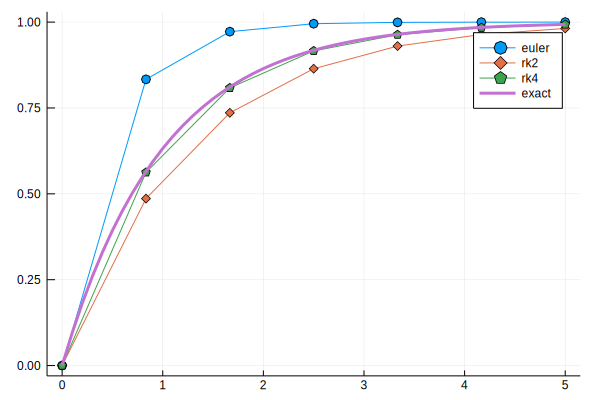

In [12]:
plot( solver(f, euler, t₀, x₀, dt, nsteps); marker = :o, label=:euler)
plot!(solver(f, rk2,   t₀, x₀, dt, nsteps); marker = :d, label=:rk2)
plot!(solver(f, rk4,   t₀, x₀, dt, nsteps); marker = :p, label=:rk4)
t = 0:0.1:5
plot!(t, 1 .- exp.(-t); line = 3, label = :exact)

# Callable object

We want to build a numerical method to solve the problem and then use it
as a function and still call the solver function.

Runge-Kutta scheme can be built using Butcher tableau :

\begin{array}{c|cccc}
 c₁  &        &        &        &        \\
 c₂  & a_{21} &        &        &        \\
 c₃  & a_{31} & a_{32} &        &        \\
 c₄  & a_{41} & a_{42} & a_{43} &        \\
 \hline
     & b_1    & b_2    & b_3    & b_4    \\
\end{array}

$$
\forall i = 1, \dotsc, q, \begin{cases}t_{n,i} &= t_n + c_i h_n, \\
y_{n,i} &= y_n + h_n \sum_{k = 1}^{i-1} a_{ik} p_{n,k}\\
p_{n,i} &= f(t_{n,i}, y_{n,i}) \end{cases}
$$

$$
y_{n+1} = y_n + h_n \sum_{k = 1}^q b_k p_{n,k}.
$$

In [13]:
mutable struct RungeKutta

    q :: Int64
    a :: Array{Float64, 2}
    b :: Array{Float64, 1}
    c :: Array{Float64, 1}

    tn :: Vector{Float64}
    yn :: Vector{Float64}
    pn :: Vector{Float64}

    function RungeKutta( a::Array{Float64,2}, b::Vector{Float64}, c::Vector{Float64})

        q = length(c)
        @assert ( length(c) == size(a,1))
        @assert ( length(b) == size(a,2))
        tn = zeros(Float64, q)
        yn = zeros(Float64, q)
        pn = zeros(Float64, q)
        new( q, a, b, c, tn, yn, pn)

    end

end

function (rk::RungeKutta)(f::Function, t::Float64, y::Float64,  h::Float64)

    for i = 1:rk.q
        rk.tn[i] = t + rk.c[i] * h
        rk.yn[i] = y + h * sum([rk.a[i,k]*rk.pn[k] for k = 1:i-1])
        rk.pn[i] = f(rk.tn[i],rk.yn[i])
    end

    t + h, y + h * sum([rk.b[k]*rk.pn[k] for k in 1:rk.q ])

end

In [14]:
function solver(f::Function,
                Method::RungeKutta,
                t₀::Float64,
                y₀::Float64, h::Float64, nsteps::Int64)

    t = zeros(Float64,nsteps)
    y = similar(t)

    t[1] = t₀
    y[1] = y₀

    for i in 2:nsteps
       t[i], y[i] = Method(f,t[i-1],y[i-1], h)
    end

    t, y

end

solver (generic function with 2 methods)

In [15]:
a = [ 0   0   0 0;
      1/2 0   0 0;
      0   1/2 0 0;
      0   0   1 0]

b = [1/6 ,1/3, 1/3, 1/6]
c = [0   ,1/2, 1/2, 1  ]

rk4_new = RungeKutta(a, b, c)

RungeKutta(4, [0.0 0.0 0.0 0.0; 0.5 0.0 0.0 0.0; 0.0 0.5 0.0 0.0; 0.0 0.0 1.0 0.0], [0.166667, 0.333333, 0.333333, 0.166667], [0.0, 0.5, 0.5, 1.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0])

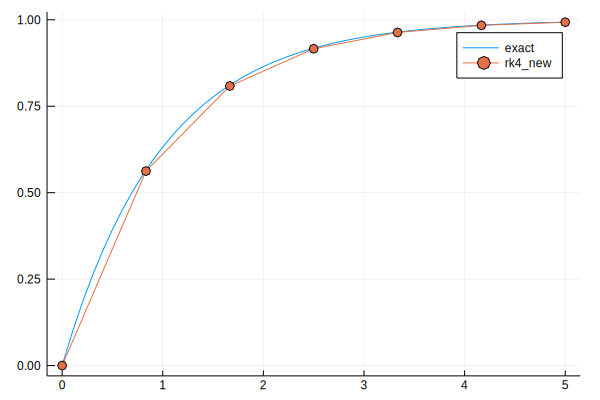

In [16]:
t = 0:0.1:5
plot(t, 1 .- exp.(-t),label = :exact)
plot!(solver(f, rk4_new, t₀, x₀, dt, nsteps), marker = :o,  label=:rk4_new)

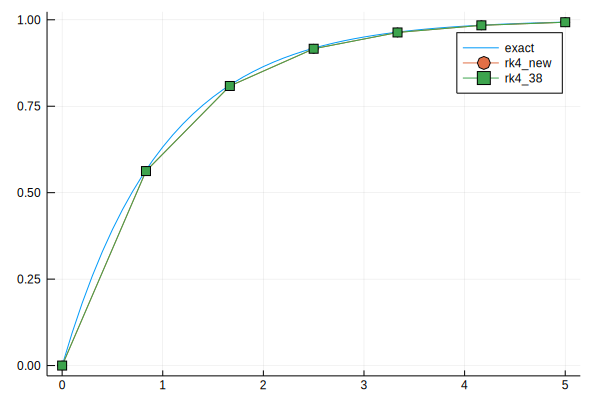

In [17]:
a = [  0   0  0  0;
     1/3   0  0  0;
    -1/3   1  0  0;
       1  -1  1  0]

b = [1/8, 3/8, 3/8, 1/8]
c = [0, 1/3,  2/3, 1]
rk4_38 = RungeKutta(a, b, c)
plot!(solver(f, rk4_38, t₀, x₀, dt, nsteps), marker = :r,  label=:rk4_38)

[Reference](https://www.juliabloggers.com/runge-kutta-methods/):Ordinary Differential Equation Solvers: Runge-Kutta Methods by Christina Lee

# Creating expressions via interpolation

Create a solver function with the method choosen at initialization.

In [18]:
macro add(x, y)
    return :($x + $y)
end

@add 2 3      ## or @add(2, 3)

5

In [19]:
macro abs(x)
    return :( $x > 0 ? $x : -$x)
end
@abs(-2), @abs(2)

(2, 2)

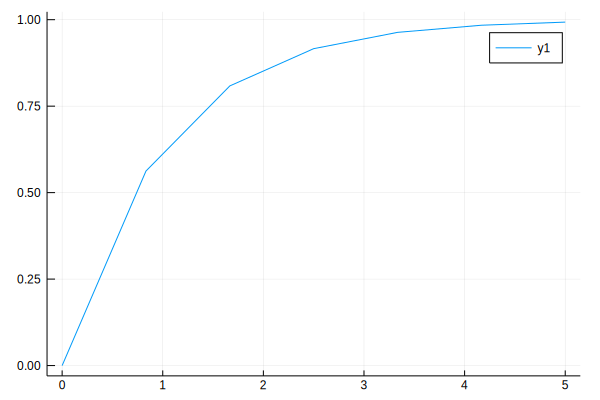

In [20]:
macro make_method( meth)
    return quote
        function (f::Function, t₀::Float64,
                  x₀::Float64, dt::Float64, nsteps::Int64)

            t = zeros(Float64,nsteps)
            x = zeros(Float64,nsteps)

            t[1] = t₀
            x[1] = x₀

            for i in 2:nsteps
               t[i], x[i] = $meth(f,t[i-1],x[i-1], dt)
            end

            return t, x
        end
    end
end

rk4_solver = @make_method rk4

plot(rk4_solver(f, t₀, x₀, dt, nsteps))

[DifferentialEquations.jl](http://docs.juliadiffeq.org/latest/)

[ODE Solvers](http://docs.juliadiffeq.org/latest/solvers/ode_solve.html#OrdinaryDiffEq.jl-1)

In [21]:
using OrdinaryDiffEq
using Plots


f(y,p,t) = 1.0 - y
y₀ = 0.0
t  = (0.0,5.0)
prob = ODEProblem(f,y₀,t)
euler  = solve(prob,Euler(), dt=1.0)
rk4  = solve(prob, RK4(), dt=1.0)
plot(euler,label="Euler")
plot!(rk4,label="RK4")
plot!(1:0.1:5, t->1. - exp(-t),lw=3,ls=:dash,label="True Solution!")

┌ Info: Recompiling stale cache file /Users/navaro/.julia/compiled/v1.0/OrdinaryDiffEq/DlSvy.ji for OrdinaryDiffEq [1dea7af3-3e70-54e6-95c3-0bf5283fa5ed]
└ @ Base loading.jl:1190


ErrorException: invalid redefinition of constant euler

In [22]:
using DifferentialEquations

function lorenz(du,u,p,t)
 du[1] = 10.0*(u[2]-u[1])
 du[2] = u[1]*(28.0-u[3]) - u[2]
 du[3] = u[1]*u[2] - (8/3)*u[3]
end

┌ Info: Recompiling stale cache file /Users/navaro/.julia/compiled/v1.0/DifferentialEquations/UQdwS.ji for DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1190


lorenz (generic function with 1 method)

In [23]:
u0 = [1.0;0.0;0.0]
tspan = (0.0,100.0)
prob = ODEProblem(lorenz,u0,tspan)
sol = solve(prob)

retcode: Success
Interpolation: 3rd order Hermite
t: 1287-element Array{Float64,1}:
   0.0                  
   3.5678604836301404e-5
   0.0003924646531993154
   0.0032624016752212923
   0.00905808176456279  
   0.0169564955927642   
   0.02769000245764448  
   0.04185634375662893  
   0.06024025665362463  
   0.0836852441654334   
   0.11336451506889586  
   0.14862131186030308  
   0.18703929175446188  
   ⋮                    
  99.17448947475748     
  99.25177886977121     
  99.3340481055892      
  99.40002509604705     
  99.47321520444633     
  99.54429913558833     
  99.6304176475736      
  99.73556893651245     
  99.81512588011671     
  99.88533419341042     
  99.94751447208056     
 100.0                  
u: 1287-element Array{Array{Float64,1},1}:
 [1.0, 0.0, 0.0]                    
 [0.999643, 0.000998805, 1.78143e-8]
 [0.996105, 0.0109654, 2.14696e-6]  
 [0.969359, 0.0897704, 0.000143801] 
 [0.924204, 0.242289, 0.00104616]   
 [0.880045, 0.438737, 0.00342427]   
 

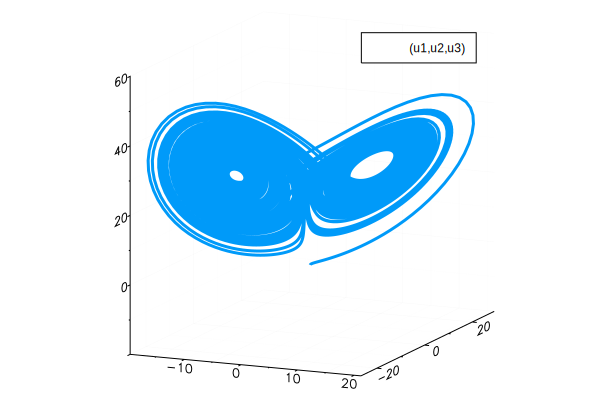

In [24]:
plot(sol,vars=(1,2,3))

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*